In [112]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

#df_clean.drop_duplicates(inplace=True)

In [114]:
#df_clean.info()

In [115]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
#df_clean.head()

In [116]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [117]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [118]:
# Ridge Regression function with RandomizedSearchCV and enhanced visualization
def ridge_regression_with_random_search(df, energy_types, features_dict, alphas):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Ridge Regression with RandomizedSearchCV
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_ridge.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(best_ridge.coef_)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_ridge, best_r2, mse_best

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Energy Type: petrol
Best Alpha: 4.641588833612782
Best R^2 Score: 0.6679482819069393
Mean Squared Error: 114.98749307596977


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


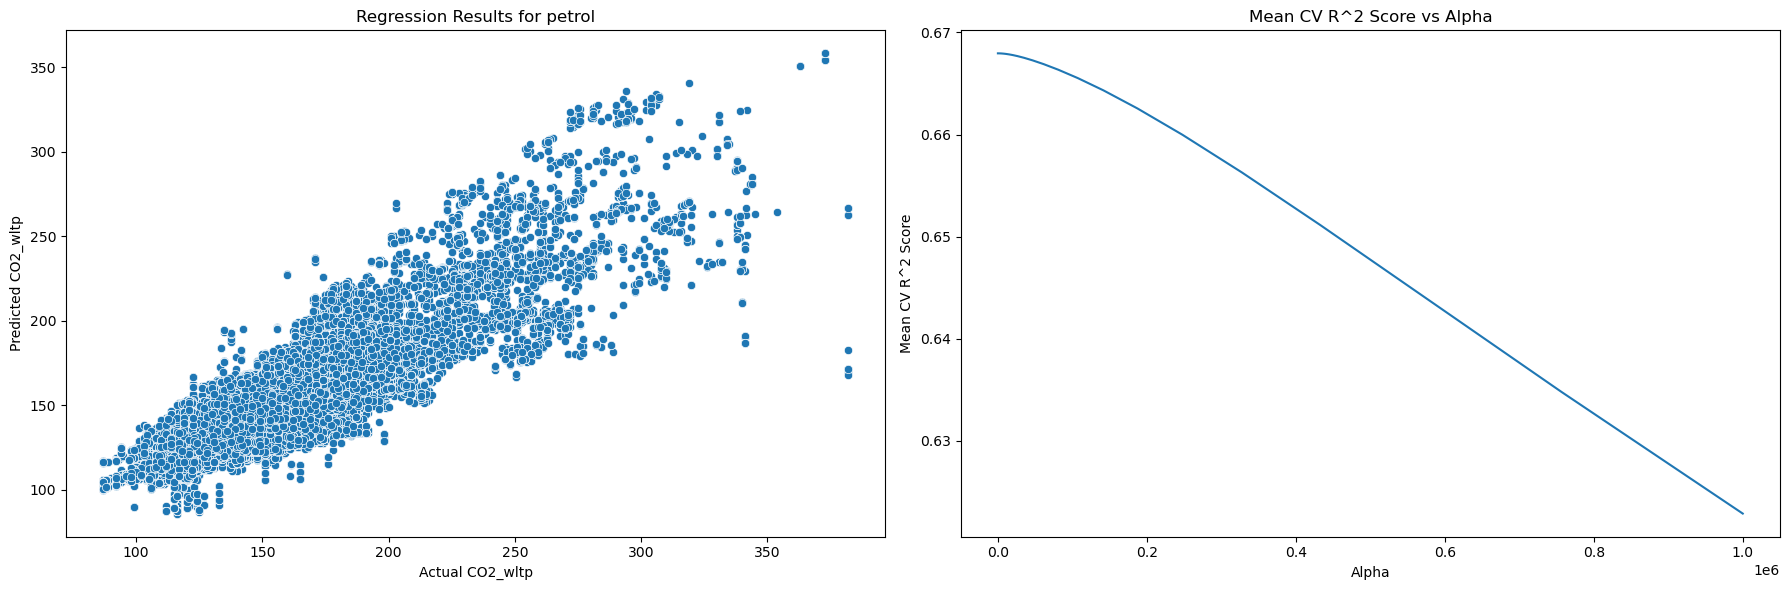

Feature Importances:
Power_KW: 12.110899829557306
Test_mass: 7.663085691695972
year: 5.775422016037845
Engine_cm3: 4.74219146344866
Fuel consumption: 4.682205656204573
Axle_width_other_mm: 2.4224194405920425
Kg_veh: 1.8923447231559665
Erwltp (g/km): 1.6846366058806368
Eco-innovation program: 0.8246286449582836
Axle_width_steer_mm: 0.6037765027985011
Wheelbase_mm: 0.24770552563818676
El_Consumpt_whkm: 0.2435030582241689


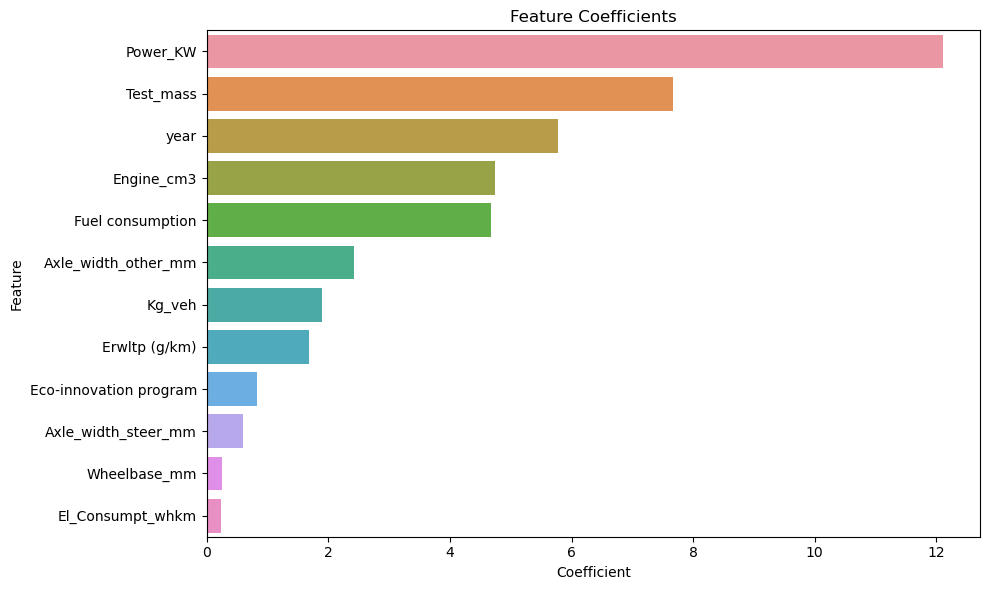

Energy Type: diesel
Best Alpha: 3.5111917342151346
Best R^2 Score: 0.8594732062514058
Mean Squared Error: 65.38888463406302


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


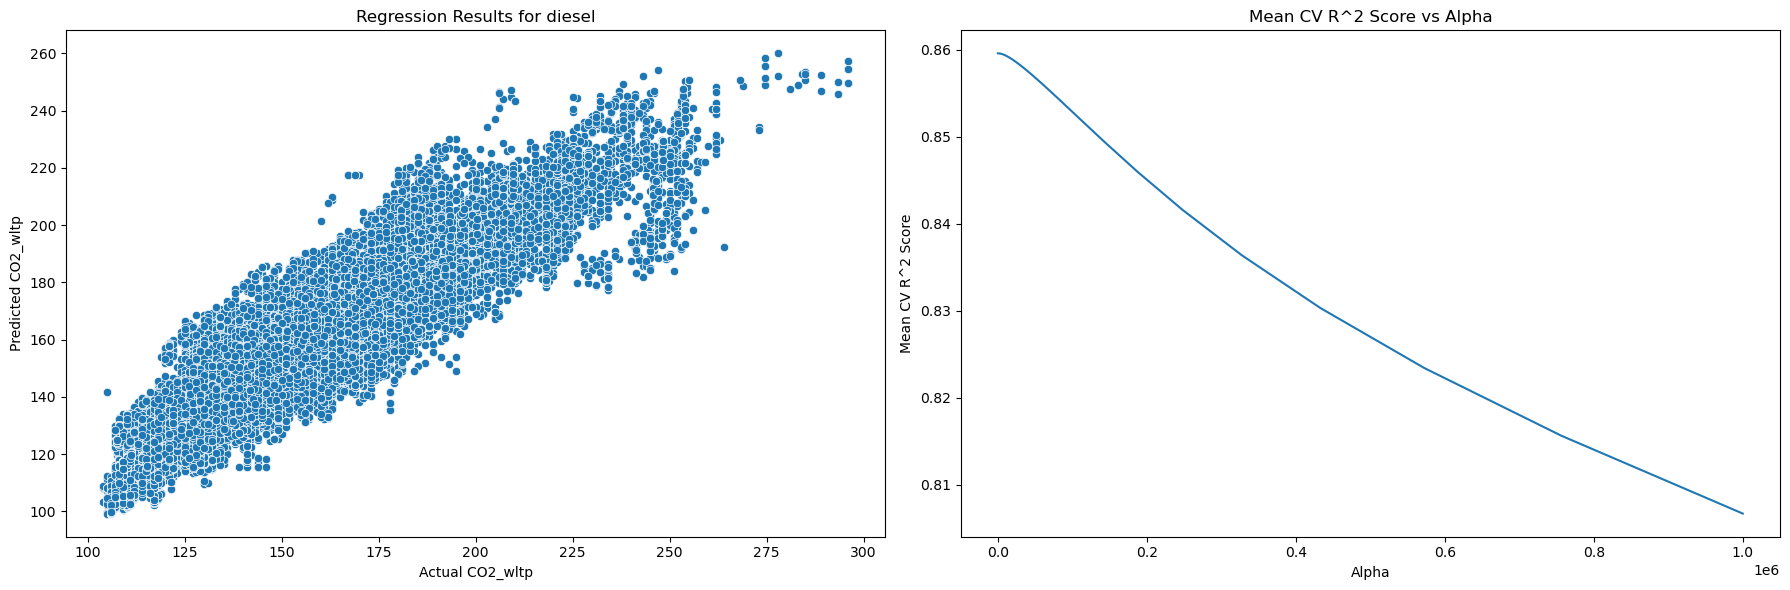

Feature Importances:
Test_mass: 17.894395491980717
Kg_veh: 5.025131288107609
Wheelbase_mm: 3.7113402590106293
year: 3.3866115754812163
Axle_width_steer_mm: 2.7278319443048
Fuel consumption: 1.9169803478415095
Eco-innovation program: 1.894541369787165
Axle_width_other_mm: 1.8043915057310205
Power_KW: 1.1972926030637536
Erwltp (g/km): 0.5800701059198722
Engine_cm3: 0.17956939764360105
El_Consumpt_whkm: 0.03771345759283544


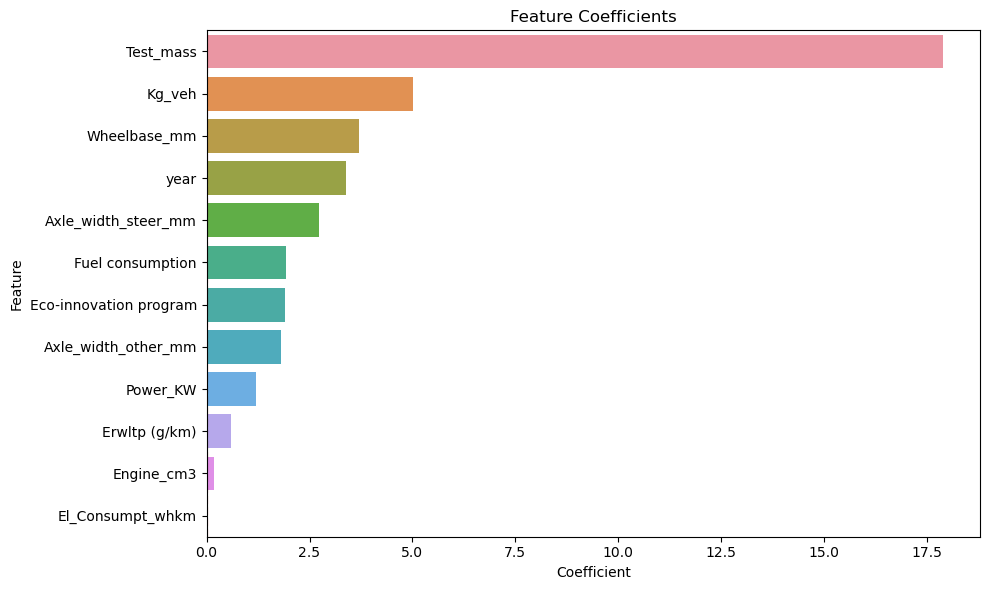

Energy Type: lpg
Best Alpha: 0.21544346900318867
Best R^2 Score: 0.8891758181594672
Mean Squared Error: 7.894706857532399


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


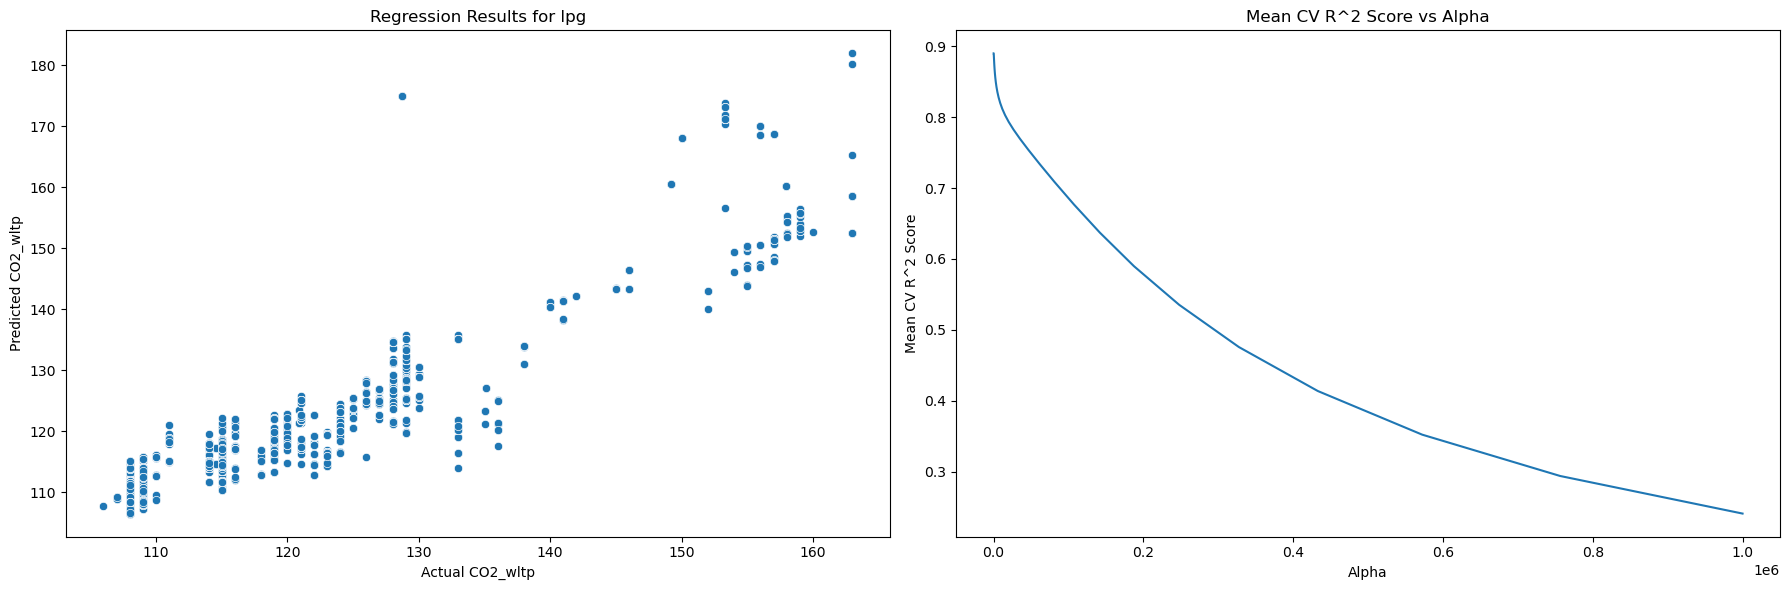

Feature Importances:
Test_mass: 12.76343533252621
Axle_width_other_mm: 10.87569636588842
Axle_width_steer_mm: 10.70481581433445
Kg_veh: 6.567354476607322
Wheelbase_mm: 2.680289367024304
year: 2.635055822768909
Eco-innovation program: 2.1988676638918903
Erwltp (g/km): 1.8914058149777633
Engine_cm3: 1.8051170032214265
Power_KW: 1.6415704662969495
Fuel consumption: 0.9973440984218831
Electric range (km): 0.0


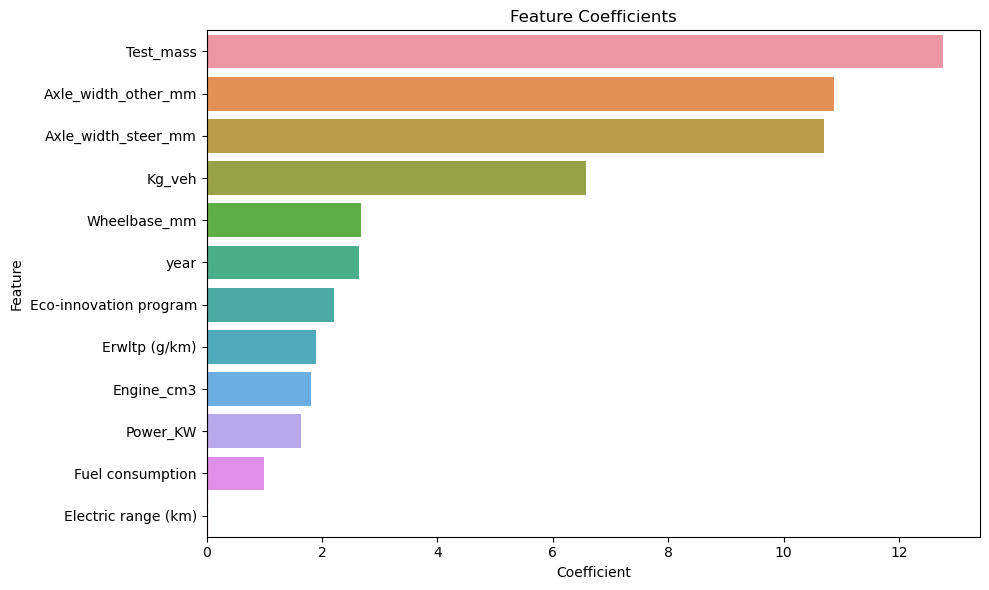

Energy Type: hybrid petrol
Best Alpha: 132.19411484660287
Best R^2 Score: 0.4121115462820816
Mean Squared Error: 176.6770354852758


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


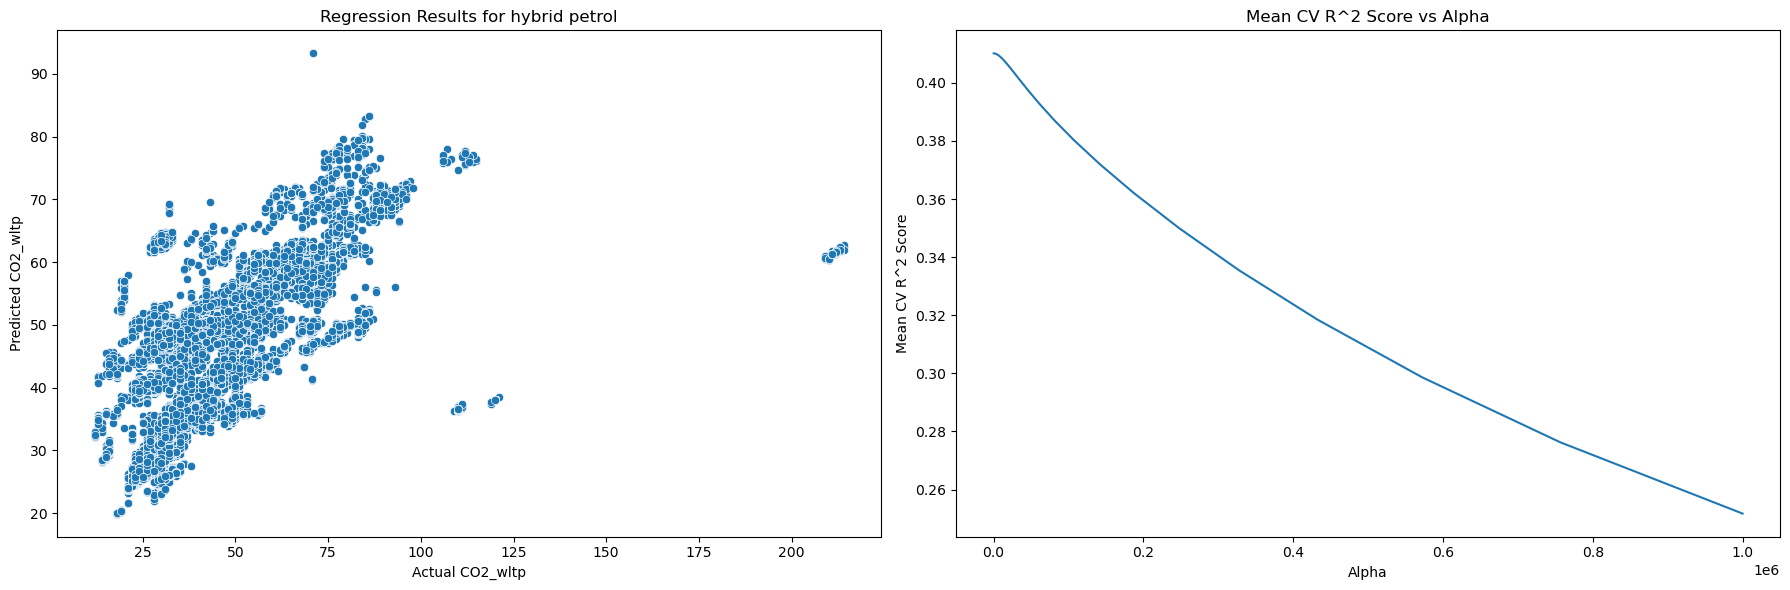

Feature Importances:
Fuel consumption: 6.836973253390078
Test_mass: 5.403761533853324
Kg_veh: 3.9846497047301486
Electric range (km): 2.0722835772825277
Engine_cm3: 1.55660267836312
Power_KW: 1.4076032960599374
Axle_width_other_mm: 1.121397780911326
El_Consumpt_whkm: 0.8162938655067116
Axle_width_steer_mm: 0.7209163761748919
Wheelbase_mm: 0.3662063988645056
year: 0.16625945730066793
Eco-innovation program: 0.05765276122914874


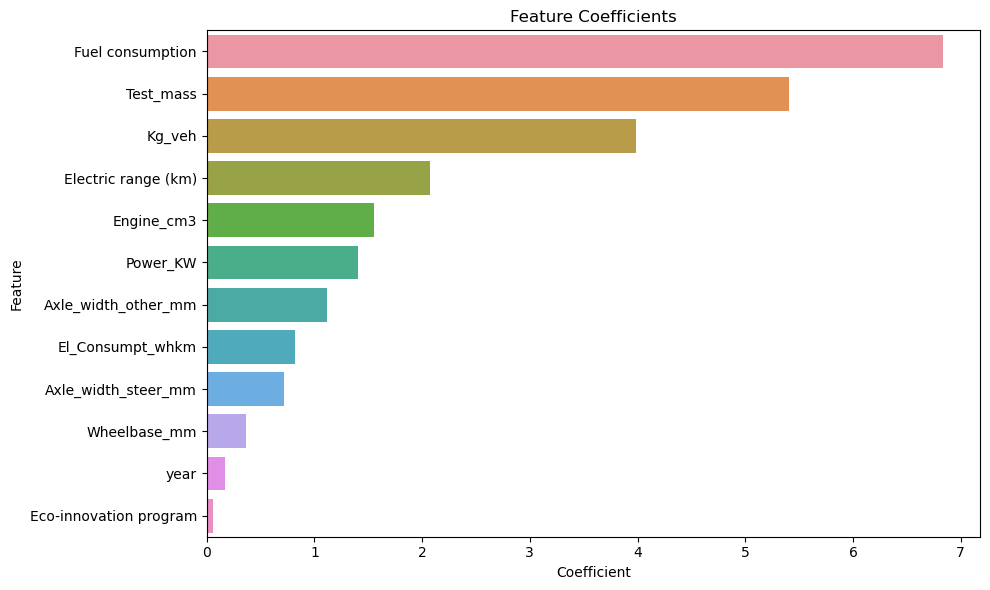

Energy Type: hybrid diesel
Best Alpha: 0.37649358067924715
Best R^2 Score: 0.9928577613621226
Mean Squared Error: 1.2544766107856626


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


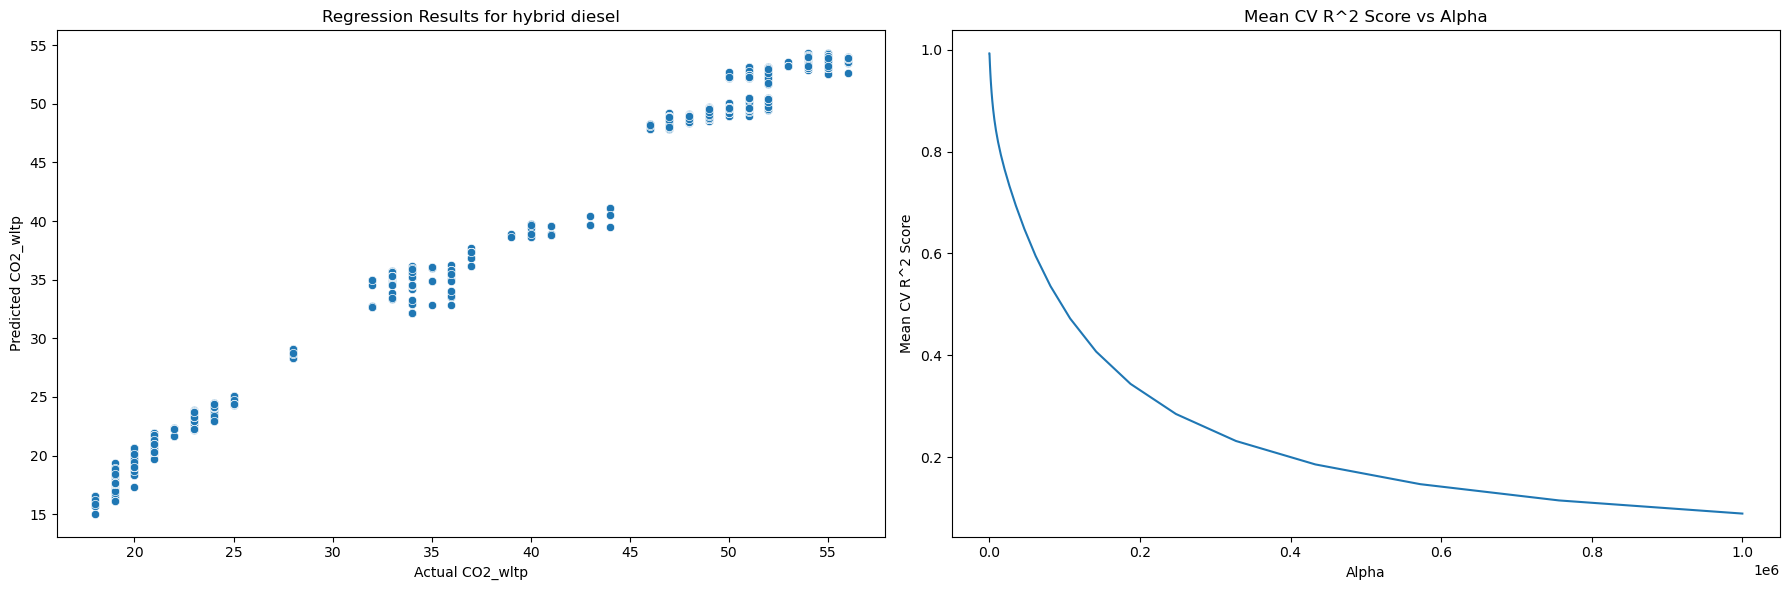

Feature Importances:
Electric range (km): 15.948411381832116
Axle_width_steer_mm: 6.27380309656558
Kg_veh: 5.529611490595149
Axle_width_other_mm: 4.510057566202431
Test_mass: 1.0054842504743948
Wheelbase_mm: 0.8948144408233337
El_Consumpt_whkm: 0.622540745815532
Fuel consumption: 0.26612180957703746
year: 0.2425321897203462
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


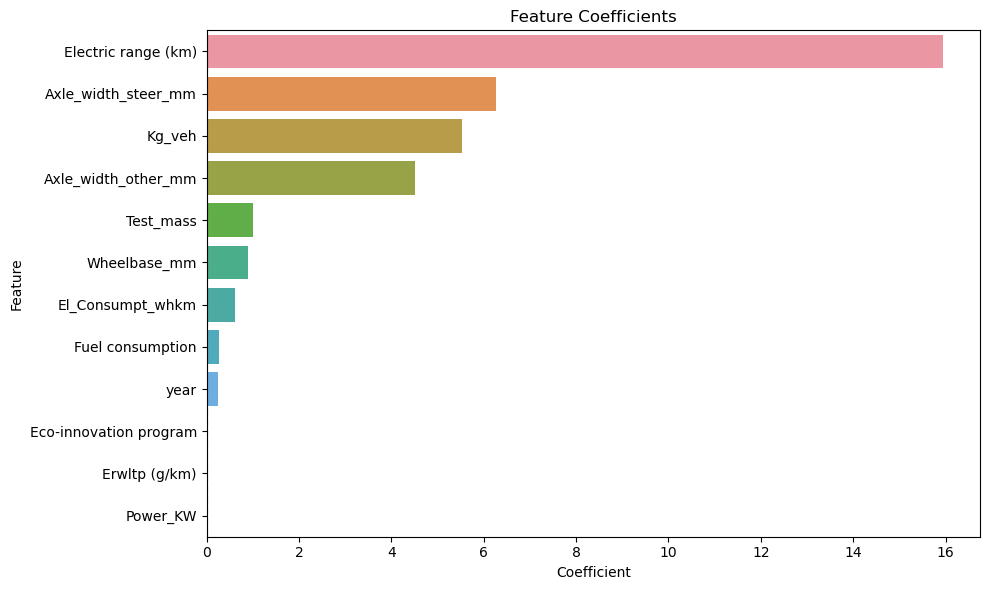

In [119]:
# Apply Ridge Regression for each energy type and all together with enhanced visualization
alphas = np.logspace(-6, 6, 100)
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression_with_random_search(df_clean, energy, features_dict, alphas)

Energy Type: All
Best Alpha: 1e-06
Best R^2 Score: 0.7156168413146361
Mean Squared Error: 212.87970949425727


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


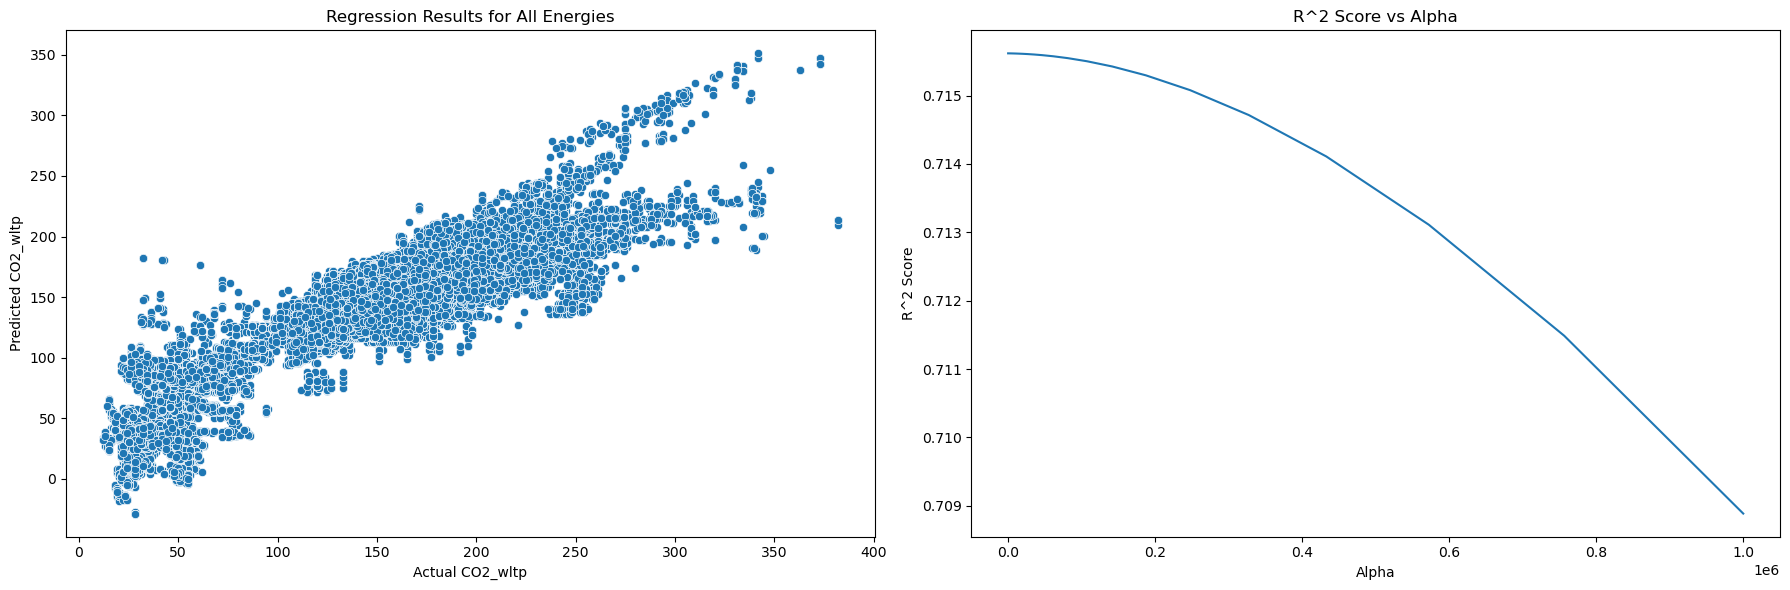

Feature Importances:
El_Consumpt_whkm: 13.530139312318067
Fuel consumption: 10.73499819716623
year: 5.864787736846044
Engine_cm3: 5.315458222615694
Wheelbase_mm: 2.727405465494711
Power_KW: 2.602688792731848
Axle_width_other_mm: 2.196291189822378
Electric range (km): 1.8067690318139626
Axle_width_steer_mm: 1.2358421260839485
Erwltp (g/km): 1.0790580629062418
Test_mass: 0.5792292525177066
Kg_veh: 0.18155231392443327
Eco-innovation program: 0.0616644629124627


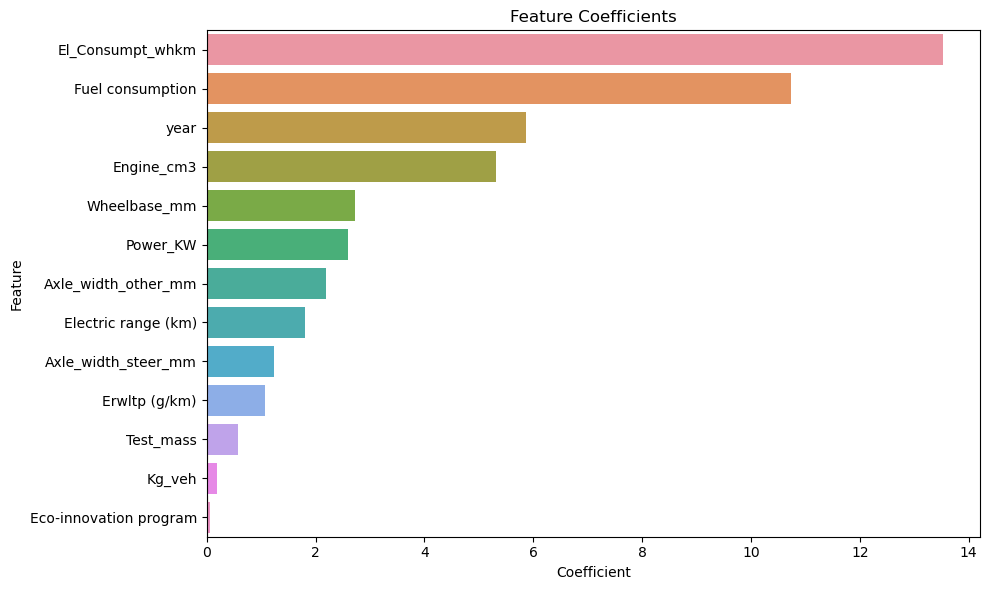

In [120]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression_with_alphas(df_clean, all_energies, features_dict, alphas)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


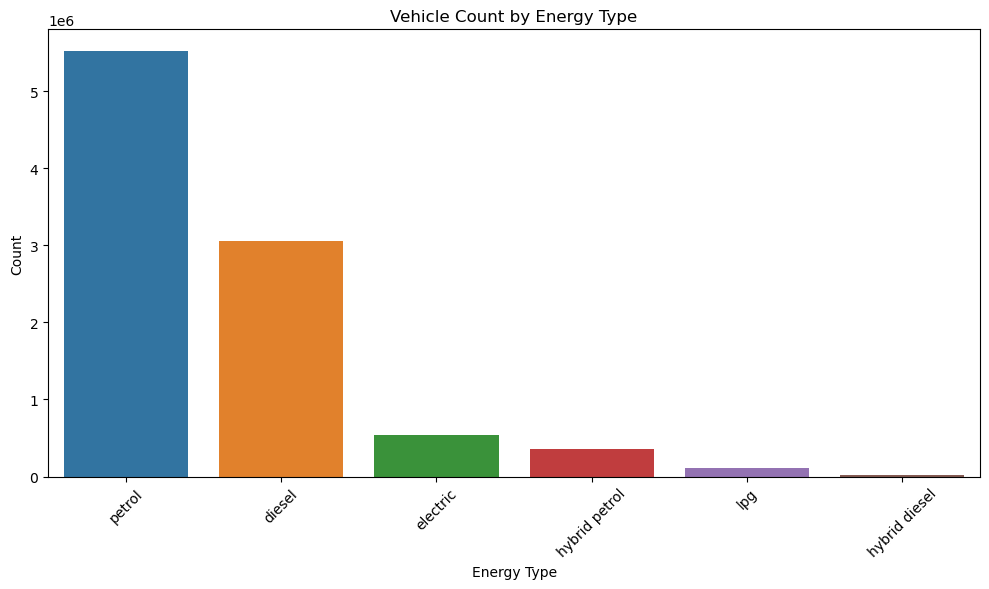

In [121]:
def visualize_vehicle_count_by_energy(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Energy', order=df['Energy'].value_counts().index)
    plt.title('Vehicle Count by Energy Type')
    plt.xlabel('Energy Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_vehicle_count_by_energy(df_clean)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


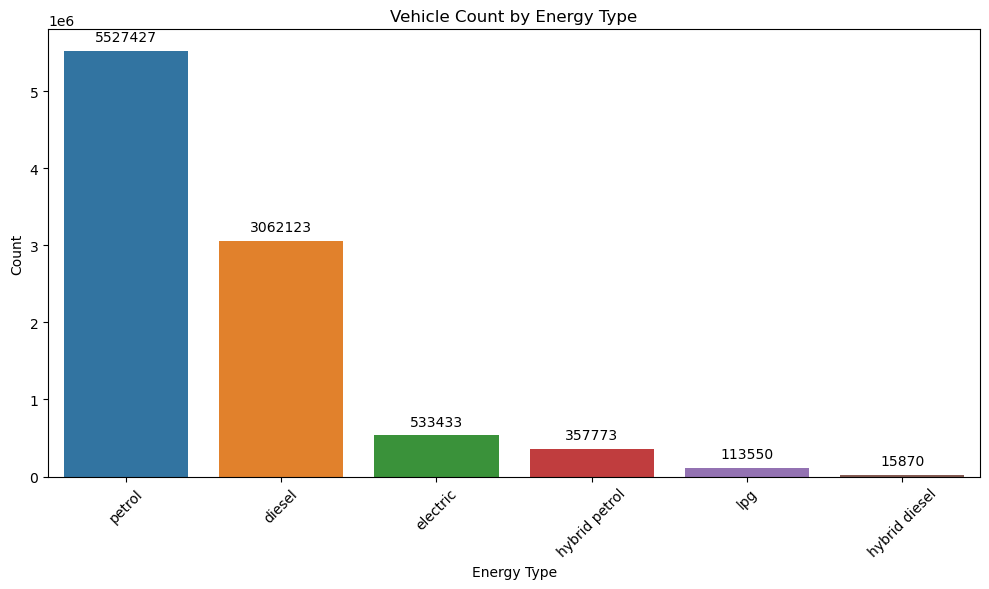

In [122]:
# Assuming df_Clean has been loaded as per the previous context
# Visualize vehicle count by Energy
def visualize_vehicle_count_by_energy(df):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x='Energy', order=df['Energy'].value_counts().index)
    
    # Add count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    
    plt.title('Vehicle Count by Energy Type')
    plt.xlabel('Energy Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_vehicle_count_by_energy(df_clean)